In [1]:
import os, json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### This libraries are used in the third point to plot over a Madrid map. To use it, has to be created a new environment in anaconda call ox. "https://osmnx.readthedocs.io/en/stable/"

In [2]:
import osmnx as ox
import networkx as nx
import folium

In [3]:
from igraph import *
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import numpy as np

# From edges.csv to dataframe for measuring net station flow

#### Reading csv into dataframe

In [4]:
stations = pd.read_csv("BasesBicimad.csv", sep=';')

In [5]:
data = pd.read_csv("edges2.csv", sep=',')

#### Editing column names

In [6]:
# Setting correct column names for dataframe

new_cols = ['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'ageRange', 'idplug_station',
       'unplug_hourTime', 'zip_code']

data.columns = new_cols

In [7]:
# Making column names lower case
data.columns = data.columns.str.lower()

#### Creating time-related features

In [8]:
# Dropping nan values so that "travel_time" can be converted into date_time object
data.drop("zip_code", axis=1, inplace=True) # dropping zip code because has many nans
#data.dropna(inplace = True) # Dropping rows with nans (very few)

# Checking Nans
print(f"Number of missing values:\n{data.isna().mean()}")


Number of missing values:
_id                 0.0
user_day_code       0.0
idplug_base         0.0
user_type           0.0
idunplug_base       0.0
travel_time         0.0
idunplug_station    0.0
agerange            0.0
idplug_station      0.0
unplug_hourtime     0.0
dtype: float64


In [9]:
# convert seconds to timedelta
data["travel_timedelta"] = [
    pd.Timedelta(seconds=sec) for sec in data["travel_time"]
]

In [10]:
# convert endTime to datetime object
data["unplug_hourtime"] = pd.to_datetime(data["unplug_hourtime"])

# creating new column "plug_time" by adding "travel_time" to "unplug_hourtime"
data["plug_time"] = data["unplug_hourtime"] + data["travel_timedelta"]

# time-related features
data["date"] = data["unplug_hourtime"].dt.date
data["month"] = data["unplug_hourtime"].dt.month
data["week"] = data["unplug_hourtime"].dt.week
data["day"] = data["unplug_hourtime"].dt.day
data["hour"] = data["unplug_hourtime"].dt.hour
data["year"] = data["unplug_hourtime"].dt.year
data["weekday"] = data["unplug_hourtime"].dt.weekday
data["weekend"] = data["weekday"].map(lambda x: 1*(x>4))
data["year_month"] = data["unplug_hourtime"].dt.strftime("%y%m")
data["year_day"] = data["unplug_hourtime"].dt.strftime("%y%d")

C:\Users\fredi\AppData\Local\Temp\ipykernel_2948\2640454407.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week"] = data["unplug_hourtime"].dt.week


In [11]:
# Checking new column types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795877 entries, 0 to 6795876
Data columns (total 22 columns):
 #   Column            Dtype              
---  ------            -----              
 0   _id               object             
 1   user_day_code     object             
 2   idplug_base       int64              
 3   user_type         int64              
 4   idunplug_base     int64              
 5   travel_time       int64              
 6   idunplug_station  int64              
 7   agerange          int64              
 8   idplug_station    int64              
 9   unplug_hourtime   datetime64[ns, UTC]
 10  travel_timedelta  timedelta64[ns]    
 11  plug_time         datetime64[ns, UTC]
 12  date              object             
 13  month             int64              
 14  week              int64              
 15  day               int64              
 16  hour              int64              
 17  year              int64              
 18  weekday           int6

# 1. EDA

# Basic EDA


In [12]:
# Total number of journeys

len(data)

6795877

In [13]:
# Total number of stations

len(data.idplug_station.unique())

265

In [14]:
edges = data.copy()
nodes = stations.copy()

In [15]:
nodes.rename(columns={'Número':'id'}, inplace=True)

In [16]:
edges.rename(columns={'idunplug_station':'from', 'idplug_station':'to', 'travel_time':'weight'}, inplace=True)

In [17]:
edges = edges[['from','to', 'weight']]

In [18]:
routes = edges.set_index('from').join(nodes.set_index('id'), how='inner', lsuffix='left', rsuffix='right')\
.rename(columns={'Longitud': 'src_longitud', 'Latitud':'src_latitud'})\
.reset_index().rename(columns={'index': 'from'})\
.set_index('to').join(nodes.set_index('id'), how='inner', lsuffix='left', rsuffix='right')\
.rename(columns={'Longitud': 'dst_longitud', 'Latitud':'dst_latitud'})\
.reset_index().rename(columns={'index': 'to'})

routes['code_route'] = routes['from'].astype('str').str.cat(routes['to'].astype('str'))

routes_unique = routes.groupby('code_route').mean()

routes_unique[['from', 'to']] = routes_unique[['from', 'to']].astype('int')

In [19]:
g_data = Graph.DataFrame(edges=routes_unique, vertices=nodes, directed=False, use_vids=True)

# Degrees

In [20]:
g_data.vs['degree']=g_data.degree(mode='all')

In [21]:
degree_list = g_data.degree()
degree_data = pd.DataFrame(degree_list)

degree_data.shape

(264, 1)

In [22]:
degree_data.describe()

,0
count,264.000000
mean,433.833333
std,116.006632
min,0.000000
25%,430.750000
50%,473.000000
75%,496.000000
max,540.000000


(array([ 4.,  0.,  1.,  5.,  2.,  1.,  1.,  2.,  4.,  1.,  0.,  0.,  0.,
         0.,  0.,  2.,  7.,  3.,  2.,  0.,  2.,  6., 14., 10., 17., 31.,
        44., 62., 26., 17.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.,
        198., 216., 234., 252., 270., 288., 306., 324., 342., 360., 378.,
        396., 414., 432., 450., 468., 486., 504., 522., 540.]),
 <BarContainer object of 30 artists>)

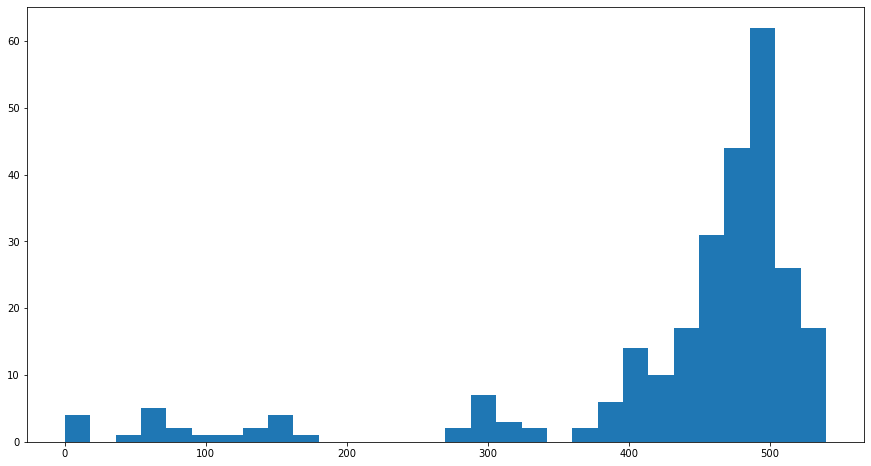

In [23]:
plt.figure(figsize=(15,8))
plt.hist(g_data.vs['degree'], bins=30)

In [24]:
min(g_data.vs['degree'])

0

In [25]:
Graph.maxdegree(g_data)

537

# Diameter and Average Path Length

In [26]:
Graph.diameter(g_data)

2

In [27]:
Graph.average_path_length(g_data)

1.1081081081081081

# Node Centrality

Betweenness

In [28]:
g_data.vs["betweenness"] = g_data.vs.betweenness()

In [29]:
min(g_data.vs['betweenness'])

0.0

In [30]:
max(g_data.vs['betweenness'])

74.2436078257997

Closeness

In [31]:
g_data.vs["closeness"] = g_data.vs.closeness()

In [32]:
min(g_data.vs['closeness'])

nan

In [33]:
max(g_data.vs['closeness'][1:])

0.9885496183206107

In [34]:
largest = g_data.clusters().giant()

In [35]:
largest.vs["closeness"]=largest.closeness()

In [36]:
max(largest.vs["closeness"])

0.9885496183206107

# Node Importance

In [37]:
node_df = pd.DataFrame({attr: g_data.vs[attr] for attr in g_data.vertex_attributes()})
node_df_largest = pd.DataFrame({attr: largest.vs[attr] for attr in largest.vertex_attributes()})

In [38]:
node_df.sort_values(by=["degree"], ascending=False).head() #nodes with highest degree

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion,degree,betweenness,closeness
38,38,439637,"4473651,64",41813,01 CENTRO,01-01 PALACIO,"SAN FRANCISCO, CARRERA, DE",1,BiciMAD,24,-3.711444,40.411296,"SAN FRANCISCO, CARRERA, DE, 1",540,44.551657,0.981061
40,40,"440207,51","4473923,52",41813,01 CENTRO,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",537,74.243608,0.977358
50,50,"441180,67","4473307,92",41813,01 CENTRO,01-02 EMBAJADORES,"SANTA ISABEL, CALLE, DE",57,BiciMAD,24,-3.693220,40.408310,"SANTA ISABEL, CALLE, DE, 57",534,57.046122,0.977358
37,37,"439409,3","4473605,14",41813,01 CENTRO,01-01 PALACIO,"SAN FRANCISCO, PLAZA, DE",5,BiciMAD,24,-3.714123,40.410861,"SAN FRANCISCO, PLAZA, DE, 5",532,28.089960,0.959259
30,30,"439635,83","4474544,08",41813,01 CENTRO,01-01 PALACIO,"PAVIA, CALLE, DE",6,BiciMAD,27,-3.711543,40.419336,"PAVIA, CALLE, DE, 6",530,45.326111,0.977358


In [39]:
node_df.sort_values(by=["betweenness"], ascending=False).head() #nodes with highest betweenness

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion,degree,betweenness,closeness
40,40,"440207,51","4473923,52",41813,01 CENTRO,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",537,74.243608,0.977358
50,50,"441180,67","4473307,92",41813,01 CENTRO,01-02 EMBAJADORES,"SANTA ISABEL, CALLE, DE",57,BiciMAD,24,-3.693220,40.408310,"SANTA ISABEL, CALLE, DE, 57",534,57.046122,0.977358
170,168,"440948,66","4472895,98",43752,02 ARGANZUELA,02-06 PALOS DE MOGUER,"SANTA MARIA DE LA CABEZA, PASEO, DE",frente 32,BiciMAD,24,-3.695916,40.404583,"SANTA MARIA DE LA CABEZA, PASEO, DE, frente 32",523,55.196801,0.988550
60,60,"441616,3","4474541,2",41813,03 RETIRO,03-05 JERÓNIMOS,"INDEPENDENCIA, PLAZA, DE LA",7,BiciMAD,24,-3.688199,40.419451,"INDEPENDENCIA, PLAZA, DE LA, 7",527,50.542316,0.977358
80,81,"441288,14","4473447,57",41813,03 RETIRO,03-05 JERÓNIMOS,"CLAUDIO MOYANO, CALLE, DE",S/N,BiciMAD,24,-3.691966,40.409576,"CLAUDIO MOYANO, CALLE, DE, S/N",528,45.477881,0.981061


In [40]:
node_df.sort_values(by=["closeness"], ascending=False).head() #nodes with highest closeness

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion,degree,betweenness,closeness
170,168,"440948,66","4472895,98",43752,02 ARGANZUELA,02-06 PALOS DE MOGUER,"SANTA MARIA DE LA CABEZA, PASEO, DE",frente 32,BiciMAD,24,-3.695916,40.404583,"SANTA MARIA DE LA CABEZA, PASEO, DE, frente 32",523,55.196801,0.988550
102,103,"441766,91","4475752,49",41813,04 SALAMANCA,04-06 CASTELLANA,"JOSE ORTEGA Y GASSET, CALLE, DE",4,BiciMAD,24,-3.686535,40.430373,"JOSE ORTEGA Y GASSET, CALLE, DE, 4",479,34.848531,0.984791
38,38,439637,"4473651,64",41813,01 CENTRO,01-01 PALACIO,"SAN FRANCISCO, CARRERA, DE",1,BiciMAD,24,-3.711444,40.411296,"SAN FRANCISCO, CARRERA, DE, 1",540,44.551657,0.981061
80,81,"441288,14","4473447,57",41813,03 RETIRO,03-05 JERÓNIMOS,"CLAUDIO MOYANO, CALLE, DE",S/N,BiciMAD,24,-3.691966,40.409576,"CLAUDIO MOYANO, CALLE, DE, S/N",528,45.477881,0.981061
130,128,"439313,53","4476733,24",42186,07 CHAMBERÍ,07-01 GAZTAMBIDE,"CEA BERMUDEZ, CALLE, DE",59,BiciMAD,24,-3.715551,40.439033,"CEA BERMUDEZ, CALLE, DE, 59",515,25.099230,0.977358


In [41]:
node_df_largest.sort_values(by=["closeness"], ascending=False).head()

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion,degree,betweenness,closeness
169,168,"440948,66","4472895,98",43752,02 ARGANZUELA,02-06 PALOS DE MOGUER,"SANTA MARIA DE LA CABEZA, PASEO, DE",frente 32,BiciMAD,24,-3.695916,40.404583,"SANTA MARIA DE LA CABEZA, PASEO, DE, frente 32",523,55.196801,0.988550
101,103,"441766,91","4475752,49",41813,04 SALAMANCA,04-06 CASTELLANA,"JOSE ORTEGA Y GASSET, CALLE, DE",4,BiciMAD,24,-3.686535,40.430373,"JOSE ORTEGA Y GASSET, CALLE, DE, 4",479,34.848531,0.984791
37,38,439637,"4473651,64",41813,01 CENTRO,01-01 PALACIO,"SAN FRANCISCO, CARRERA, DE",1,BiciMAD,24,-3.711444,40.411296,"SAN FRANCISCO, CARRERA, DE, 1",540,44.551657,0.981061
79,81,"441288,14","4473447,57",41813,03 RETIRO,03-05 JERÓNIMOS,"CLAUDIO MOYANO, CALLE, DE",S/N,BiciMAD,24,-3.691966,40.409576,"CLAUDIO MOYANO, CALLE, DE, S/N",528,45.477881,0.981061
129,128,"439313,53","4476733,24",42186,07 CHAMBERÍ,07-01 GAZTAMBIDE,"CEA BERMUDEZ, CALLE, DE",59,BiciMAD,24,-3.715551,40.439033,"CEA BERMUDEZ, CALLE, DE, 59",515,25.099230,0.977358


# Distribution of rides over time

[Text(0.5, 0, 'Week'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys\nfor Each Week throughout the Year')]

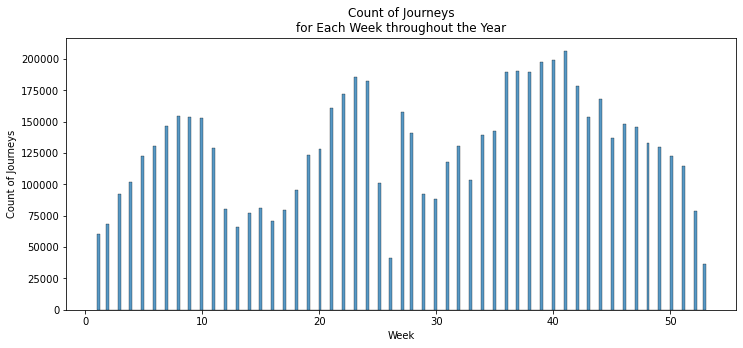

In [42]:
# Rides per week

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.histplot(data["week"], ax = ax)


graph.set(xlabel= "Week",
           ylabel="Count of Journeys",
           title= "Count of Journeys\nfor Each Week throughout the Year")

[Text(0.5, 0, 'Months in a Year'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys\n for Each Month in a Year')]

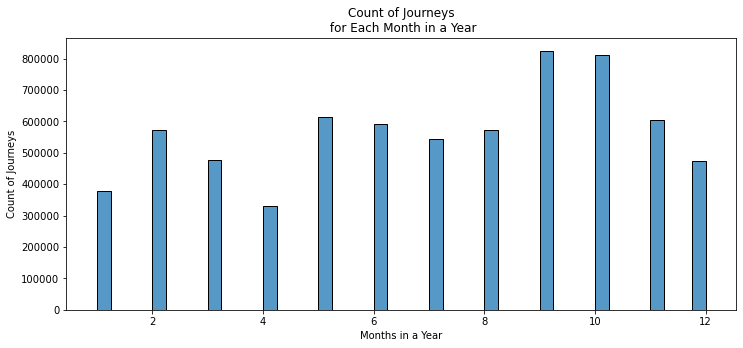

In [43]:
# Rides per month 

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.histplot(data["month"], ax = ax, binwidth = 0.25)


graph.set(xlabel= "Months in a Year",
           ylabel="Count of Journeys",
           title= "Count of Journeys\n for Each Month in a Year")

[Text(0.5, 0, 'Days in a Month'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys\n for Each day in a Month')]

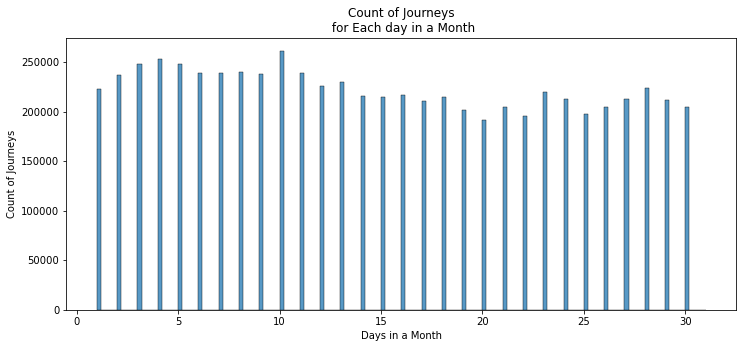

In [44]:
# Rides per Day

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.histplot(data["day"], ax = ax, binwidth = 0.2)


graph.set(xlabel= "Days in a Month",
           ylabel="Count of Journeys",
           title= "Count of Journeys\n for Each day in a Month")

[Text(0.5, 0, 'Hours in a Day'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys\n for Each Hour in a Day')]

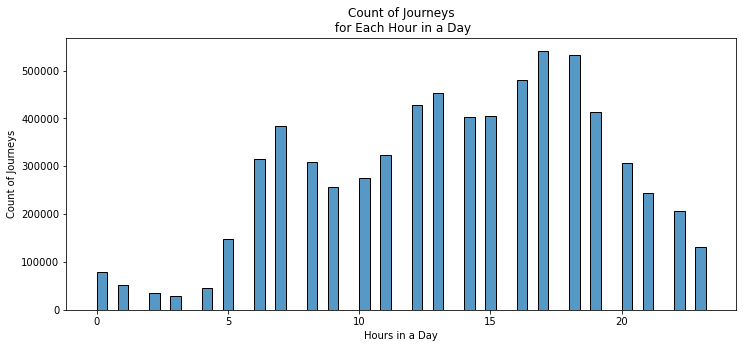

In [45]:
# Rides per hour in each day

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.histplot(data["hour"], ax = ax, binwidth = 0.4)


graph.set(xlabel= "Hours in a Day",
           ylabel="Count of Journeys",
           title= "Count of Journeys\n for Each Hour in a Day")

[Text(0.5, 0, 'Months in Datset'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys\n for Each Hour in a Day')]

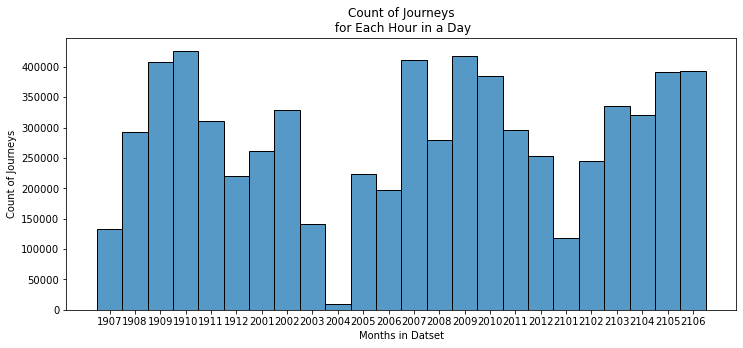

In [46]:
# Rides over entire time span of dataset

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.histplot(data["year_month"], 
                     ax = ax)


graph.set(xlabel= "Months in Datset",
           ylabel="Count of Journeys",
           title= "Count of Journeys\n for Each Hour in a Day")

[Text(0.5, 0, 'Year Month'),
 Text(0, 0.5, 'Count of Journeys'),
 Text(0.5, 1.0, 'Count of Journeys over Sampled Dataset')]

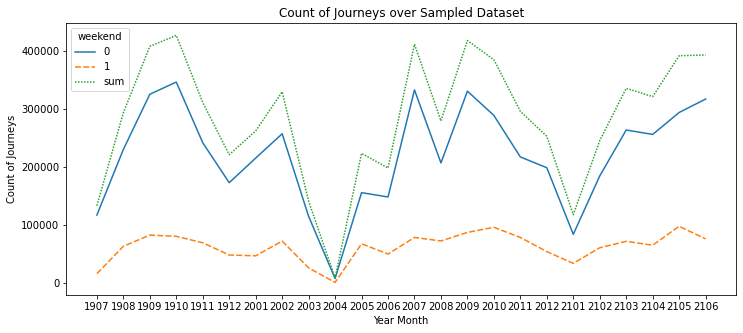

In [47]:
# Trips over time by weekend vs week

# Dataframe with plugs as columns and date as rows
date_journeys = pd.pivot_table(
                       data, 
                       values = "_id", 
                       index = "year_month", 
                       columns = "weekend", 
                       aggfunc= "count")

# Sum of trips
sum_column = date_journeys[0] + date_journeys[1]
date_journeys["sum"] = sum_column

# Plotting total trips with weekend breakdown
fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.lineplot(data = date_journeys, ax = ax)

graph.set(xlabel= "Year Month",
           ylabel='Count of Journeys',
           title='Count of Journeys over Sampled Dataset')

In [48]:
edges = data.copy()
keys = stations.copy()

Adjusting the name of the columns for the graph

In [49]:
edges.rename(columns={'idunplug_station':'from', 'idplug_station':'to', 'travel_time':'weight'}, inplace=True)

edges = edges[['from','to', 'weight']]

In [50]:
keys.rename(columns={'Número':'id'}, inplace=True)

Building the routes dataframe joining the keys and edges.

In [51]:
# Joining the dataframes and changing the names of the corresponding columns for the graph.
routes = edges.set_index('from').join(keys.set_index('id'), how='inner', lsuffix='left', rsuffix='right')\
.rename(columns={'Longitud': 'src_longitud', 'Latitud':'src_latitud'})\
.reset_index().rename(columns={'index': 'from'})\
.set_index('to').join(keys.set_index('id'), how='inner', lsuffix='left', rsuffix='right')\
.rename(columns={'Longitud': 'dst_longitud', 'Latitud':'dst_latitud'})\
.reset_index().rename(columns={'index': 'to'})

routes['code_route'] = routes['from'].astype('str').str.cat(routes['to'].astype('str'))

# Clipping the extreme values within the 99% percentile and changing the seconds to minutes.
routes['weight'] = winsorize(routes['weight'], limits=[0.01, 0.01])/60 

# Grouping by the unique routes.
routes_unique = routes.groupby('code_route').mean()

routes_unique[['from', 'to']] = routes_unique[['from', 'to']].astype('int')

# Adding the trip count.
routes_unique['trip_count'] = routes.groupby('code_route').count()['from']

Building the graph object.

In [52]:
g_data = Graph.DataFrame(edges=routes_unique, vertices=keys, directed=False, use_vids=True)
g_data.vs['degree']=g_data.degree(mode='all')

node_df = pd.DataFrame({attr: g_data.vs[attr] for attr in g_data.vertex_attributes()})

# Extra Exploratory data analysis 

With the travel time and trip count

In [53]:
pd.Series(g_data.vs['degree']).describe()

count    264.000000
mean     433.833333
std      116.006632
min        0.000000
25%      430.750000
50%      473.000000
75%      496.000000
max      540.000000
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2a3f31069b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2a3f3106f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a3f31066e0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a3f31074f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a3f31077c0>],
 'means': []}

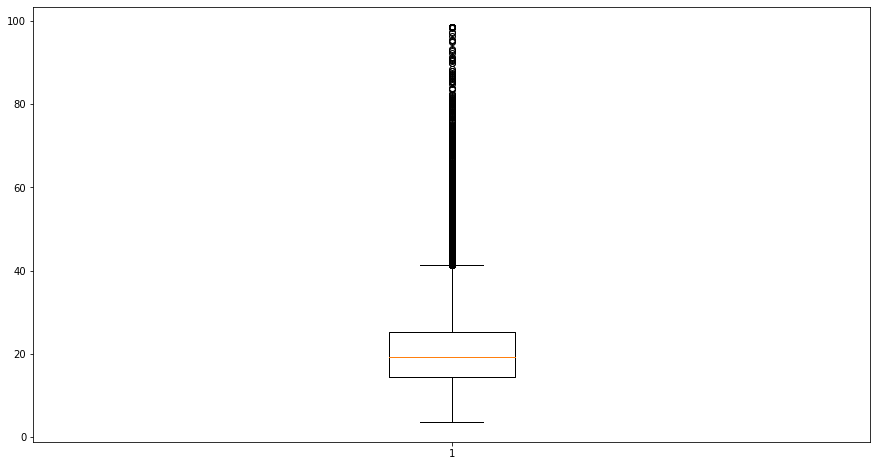

In [54]:
plt.figure(figsize=(15,8))
plt.boxplot(routes_unique['weight'])

count    57266.000000
mean        20.941798
std          9.689831
min          3.597101
25%         14.446185
50%         19.236810
75%         25.155098
max         98.583333
Name: weight, dtype: float64


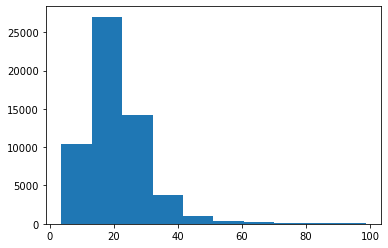

In [55]:
plt.hist(routes_unique['weight'])
print(routes_unique['weight'].describe())

The distribution of the travel time is skewed to the right.

count    57266.000000
mean       119.398771
std        163.084420
min          1.000000
25%         19.000000
50%         64.000000
75%        154.000000
max       3621.000000
Name: trip_count, dtype: float64


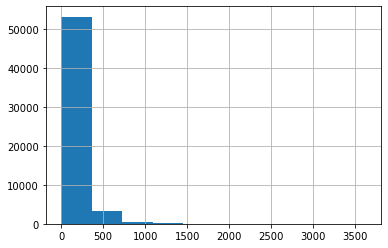

In [56]:
routes_unique['trip_count'].hist()
print(routes_unique['trip_count'].describe())

The distribution of the travel time is skewed to the right.

In [57]:
routes_unique.shape

(57266, 12)

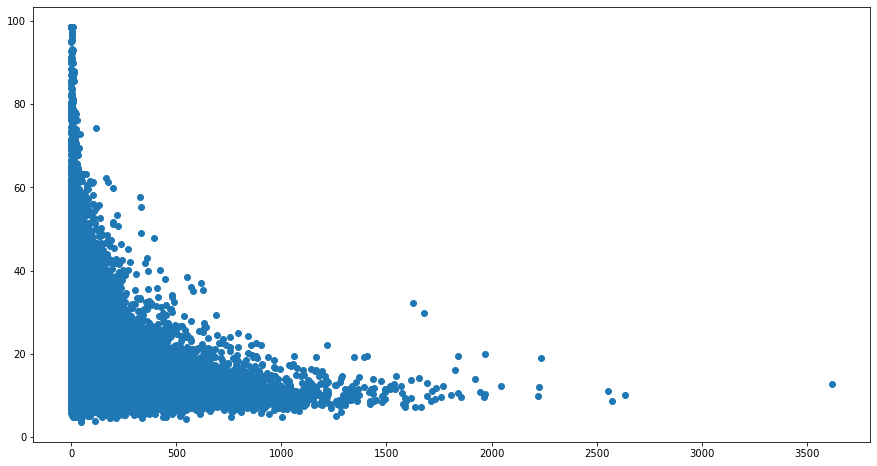

In [58]:
plt.figure(figsize=(15,8))
plt.scatter(y=routes_unique['weight'], x=routes_unique['trip_count'])

There is an exponential decreasing relationship beetween the trip count of a route and the travel time.

Filtering the most relevant routes in term of trip count with the higher travel time.

In [59]:
routes_big_time = routes_unique[(routes_unique['weight'] >= 25) & (routes_unique['trip_count'] >=150)]

routes_big_time.shape

(688, 12)

# Map

Plotting the most relevant routes and all the bases.

The bases in dark blue are the ones with higher degree.

In [60]:
import folium

def line_properties(c):
    color = "grey"
    weight = 1
    if c > 3000:
        color = 'red'
        weight = 7
    elif c > 2000:
        color = 'orange'
        weight = 5
    elif c > 1000:
        color = 'green'        
        weight = 3
    return (color,weight)    

#creates the map centering in this coordinates
m = folium.Map(location=[40.4165000, -3.7025600], zoom_start=14, height=800)

#adds stations to map
for index, row in node_df.iterrows():
    color = 'darkblue' if row['degree'] > 500 else 'blue'
    icon=folium.map.Icon(color=color,icon='bicycle',prefix='fa')
    folium.Marker(location=[row['Latitud'], row['Longitud']], popup=row['id'], icon=icon).add_to(m)

#adds routes to map
for index, row in routes_big_time.iterrows():
    (color, weight) = line_properties(row['weight'])    
    folium.PolyLine([(row['src_latitud'],row['src_longitud']),(row['dst_latitud'],row['dst_longitud'])],
                    color=color,
                    weight=weight,
                    opacity=0.5).add_to(m)
m

# 2. Ensuring availability bikes/parking

### Problem Statement: 

Ensuring supply and demand equilibrium for bikes across bike stations is fundamental for a smooth user experience. Ideally, no bike station should be too full that riders cannot find a free plug, and no bike station should be so empty that ride seekers cannot find a free bicycle. This puts pressure on the government to act quickly (either repleneshing empty stations or distributing bikes more evenly across stations) to ensure a smooth user experience. 

So, how can we identify stations that have a supply/demand disiquelibrium? 

1. Station inflow per hour: Count of records for "idplug_station" for each hour 
2. Station outflow per hour: Count of records for "idunplug_station" for each hour
3. Net station flow = station inflow - station outflow
4. Identify stations with extreme negative or positive net station flows for each hour of the day.
    - NSF >> 0 : government should move bikes away
    - NSF << 0 : government should add bikes

#### Filtering bike data for week days

In [61]:
# Filtering for working days
weekday = data[
    (data.loc[:,"day"] == 0) |
    (data.loc[:,"day"] == 1) |
    (data.loc[:,"day"] == 2) |
    (data.loc[:,"day"] == 3) |
    (data.loc[:,"day"] == 4) 
]

weekday.head(2)

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,agerange,idplug_station,unplug_hourtime,...,date,month,week,day,hour,year,weekday,weekend,year_month,year_day
0,{'$oid': '5ee862cecc8c1e839b419387'},509e6a72b7673f533912bf647d20df19305b848fbc1b89...,5,1,20,154,44,5,40,2019-07-01 00:00:00+00:00,...,2019-07-01,7,27,1,0,2019,0,0,1907,1901
1,{'$oid': '5ee862cecc8c1e839b41938c'},90069a1194c3eb9e6faecaaf4eefb7209e890c0df5aeac...,8,1,17,184,57,4,129,2019-07-01 00:00:00+00:00,...,2019-07-01,7,27,1,0,2019,0,0,1907,1901


#### Calculating "Net Station Flow" for every bike station

In [62]:
# Dataframe with plugs as columns and hours as rows
weekday_plugs = pd.pivot_table(
                       weekday, 
                       values = "_id", 
                       index = "hour", 
                       columns = "idplug_station", 
                       aggfunc= "count")

# Dataframe with plugs as columns and hours as rows
weekday_unplugs = pd.pivot_table(
                       weekday, 
                       values = "_id", 
                       index = "hour", 
                       columns = "idunplug_station", 
                       aggfunc= "count")


# Calculating net flow for each plug stations
week_day_flow = weekday_plugs - weekday_unplugs


In [63]:
# Inspecing net station flow for each station

week_day_flow.head(2)

idplug_station,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,266,267,268,269,270
hour,,,,,,,,,,,,,,,,,,,,,
0,-47.0,-35.0,-24.0,6.0,-34.0,-30.0,-28.0,-33.0,-29.0,-20.0,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,-19.0,-18.0,-41.0,-11.0,-4.0,-52.0,-38.0,-18.0,-37.0,-9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
week_day_flow.describe()

idplug_station,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,266,267,268,269,270
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,16.000000,20.000000,20.00000,20.000000,16.000000,14.000000,17.000000,17.000000,18.000000,21.000000
mean,-1.166667,-0.375000,1.416667,2.791667,1.541667,-0.083333,0.625000,1.791667,-1.000000,0.291667,...,-2.062500,-1.100000,0.55000,-0.400000,-1.562500,-0.214286,-0.058824,2.411765,-0.944444,1.095238
std,92.690540,48.810024,71.709509,62.705647,48.644209,93.021698,55.310045,33.961588,139.723329,39.126861,...,9.942962,7.100037,8.76281,10.179443,10.739142,4.593952,10.262009,26.923639,14.139940,8.233497
min,-189.000000,-77.000000,-124.000000,-158.000000,-84.000000,-199.000000,-104.000000,-94.000000,-191.000000,-96.000000,...,-16.000000,-17.000000,-9.00000,-22.000000,-23.000000,-7.000000,-15.000000,-29.000000,-29.000000,-16.000000
25%,-63.250000,-37.750000,-48.750000,-9.500000,-22.500000,-34.750000,-32.750000,-9.000000,-90.500000,-20.000000,...,-8.250000,-5.250000,-5.00000,-5.000000,-3.250000,-4.250000,-8.000000,-19.000000,-9.750000,-4.000000
50%,1.500000,-5.000000,24.500000,6.500000,-7.500000,-1.500000,-0.500000,9.000000,-24.500000,-1.500000,...,-1.000000,0.500000,-1.00000,-1.000000,-0.500000,-1.000000,-1.000000,-3.000000,1.000000,2.000000
75%,70.000000,41.250000,57.250000,22.500000,21.000000,62.500000,48.500000,23.000000,37.000000,23.750000,...,2.000000,3.500000,1.50000,7.000000,2.000000,2.500000,4.000000,8.000000,8.500000,8.000000
max,148.000000,86.000000,116.000000,137.000000,129.000000,228.000000,89.000000,57.000000,392.000000,63.000000,...,23.000000,9.000000,22.00000,16.000000,17.000000,7.000000,24.000000,72.000000,25.000000,14.000000


In [65]:
daily_flow = week_day_flow/((730) * (5/7))

#### Filtering for station pairs with highest traffic

Station pairs with highest traffic (from Alfredo)

- 9 - 149: Palacio - El Viso
- 19 - 55: Justicia - Universidad
- 111 - 80: Chamberi - Gaztambide
- 65 - 1: Jeronimos - Sol
- 175 - 43: Chopera - Embajadores
- 43 - 13: Embajadores - Universidad
- 135 - 49: Rios Rosas - Embajadores

In [66]:
# Applying heatmap for visualization to identify in and outflow stations
high_traffic = daily_flow[[9, 149, 19, 55, 111, 80, 65, 1, 175, 43, 13, 135, 49]]

heatmap = high_traffic.style.background_gradient(cmap='Greens')

heatmap

idplug_station,9,149,19,55,111,80,65,1,175,43,13,135,49
hour,,,,,,,,,,,,,
0,-0.055616,-0.015342,-0.163014,0.001918,-0.015342,0.055616,0.028767,-0.090137,-0.028767,-0.120822,-0.021096,0.151507,0.059452
1,-0.070959,-0.013425,-0.076712,-0.011507,-0.011507,0.040274,0.028767,-0.036438,-0.011507,-0.084384,-0.074795,0.070959,-0.009589
2,-0.038356,0.019178,-0.093973,-0.026849,-0.009589,0.001918,0.030685,-0.051781,0.015342,-0.017260,-0.001918,0.074795,0.000000
3,-0.019178,0.038356,-0.042192,0.017260,-0.003836,0.024932,0.003836,0.024932,-0.046027,0.007671,-0.023014,0.084384,-0.021096
4,0.009589,0.051781,0.053699,-0.021096,nan,-0.042192,0.072877,0.051781,-0.145753,-0.061370,-0.095890,0.013425,-0.140000
5,0.354795,0.024932,0.120822,-0.003836,0.026849,-0.343288,-0.034521,0.134247,-0.460274,-0.331781,-0.172603,-0.051781,-0.360548
6,0.751781,-0.418082,0.032603,-0.191781,0.197534,-0.531233,0.199452,0.255068,-0.573425,-0.864932,-0.366301,-0.258904,-0.308767
7,0.579178,-0.396986,0.172603,-0.086301,0.490959,-0.350959,0.128493,0.283836,-0.222466,-0.347123,-0.189863,-0.145753,-0.212877
8,0.186027,-0.182192,0.230137,0.057534,0.264658,-0.189863,-0.042192,0.212877,-0.082466,-0.086301,-0.017260,-0.107397,-0.080548


In [67]:
high_traffic.describe()

idplug_station,9,149,19,55,111,80,65,1,175,43,13,135,49
count,24.000000,24.000000,24.000000,24.000000,23.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.001918,0.004395,-0.000799,-0.002078,-0.008839,0.009189,0.001598,-0.002237,-0.004715,0.011187,0.002957,0.015982,-0.002557
std,0.267963,0.164229,0.144300,0.075294,0.158234,0.203621,0.089163,0.177763,0.225452,0.292627,0.136002,0.124385,0.148461
min,-0.366301,-0.418082,-0.280000,-0.191781,-0.199452,-0.531233,-0.276164,-0.362466,-0.573425,-0.864932,-0.366301,-0.258904,-0.360548
25%,-0.173562,-0.057055,-0.123219,-0.029247,-0.087260,-0.056096,-0.042671,-0.121301,-0.110753,-0.124658,-0.060411,-0.043151,-0.037397
50%,-0.046986,0.031644,0.041233,-0.004795,-0.028767,0.036438,0.016301,0.002877,0.001918,-0.004795,-0.007671,0.017260,0.009589
75%,0.070959,0.100205,0.117945,0.027329,0.019178,0.155342,0.043151,0.134247,0.122260,0.199452,0.076712,0.077192,0.072877
max,0.751781,0.251233,0.230137,0.172603,0.490959,0.291507,0.199452,0.283836,0.536986,0.471781,0.272329,0.310685,0.272329


#### Visualizing Net Station Flows

Text(0.5, 0, 'Time (hours)')

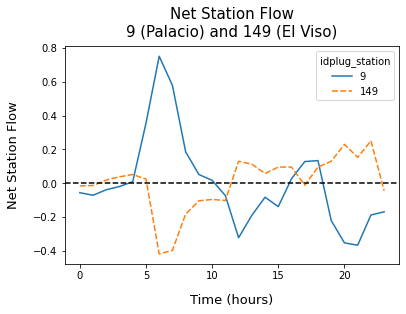

In [68]:
#9 - 149: Palacio - El Viso

#Plotting graph
graph_1 = sns.lineplot(data=high_traffic[[9, 149]])
graph_1.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n9 (Palacio) and 149 (El Viso)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)


Text(0.5, 0, 'Time (hours)')

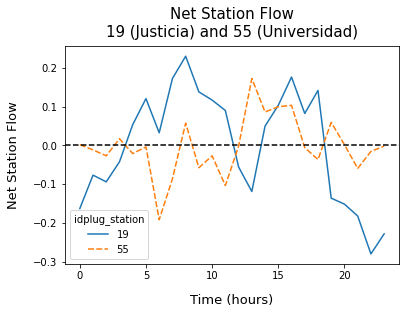

In [69]:
# 19 - 55: Justicia - Universidad

#Plotting graph
graph_2 = sns.lineplot(data=high_traffic[[19, 55]])
graph_2.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n19 (Justicia) and 55 (Universidad)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)

Text(0.5, 0, 'Time (hours)')

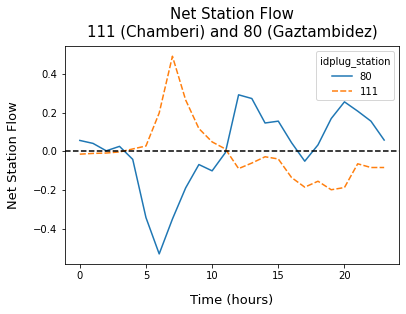

In [70]:
# 111 - 80: Chamberi - Gaztambide

#Plotting graph
graph_3 = sns.lineplot(data=high_traffic[[111, 80]])
graph_3.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n111 (Chamberi) and 80 (Gaztambidez)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)


Text(0.5, 0, 'Time (hours)')

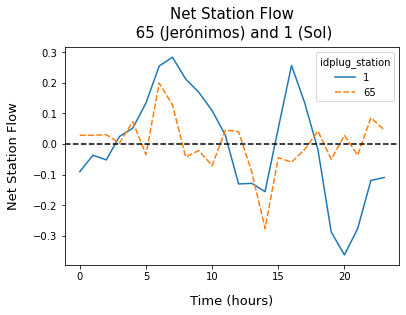

In [71]:
#65 - 1: Jeronimos - Sol

#Plotting graph
graph_4 = sns.lineplot(data=high_traffic[[65, 1]])
graph_4.axhline(0, linestyle  = "--", color = "black")


# Annotating Graph
plt.title("Net Station Flow\n 65 (Jerónimos) and 1 (Sol)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)


Text(0.5, 0, 'Time (hours)')

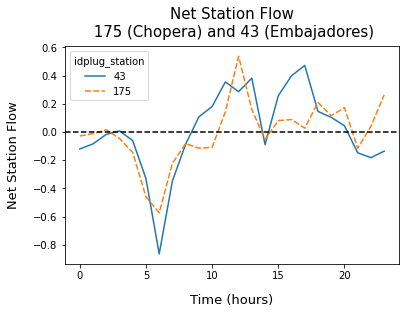

In [72]:
#175 - 43: Chopera - Embajadores

#Plotting Graph
graph_5 = sns.lineplot(data=high_traffic[[175, 43]])
graph_5.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n 175 (Chopera) and 43 (Embajadores)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)


Text(0.5, 0, 'Time (hours)')

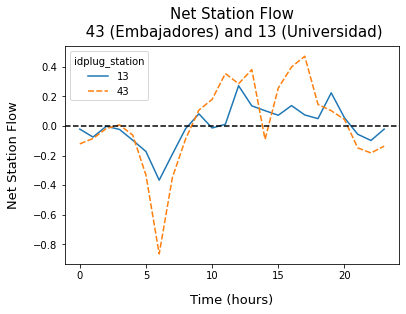

In [73]:
#43 - 13: Embajadores - Universidad

#Plotting Graph
graph_6 = sns.lineplot(data=high_traffic[[43, 13]])
graph_6.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n 43 (Embajadores) and 13 (Universidad)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)

Text(0.5, 0, 'Time (hours)')

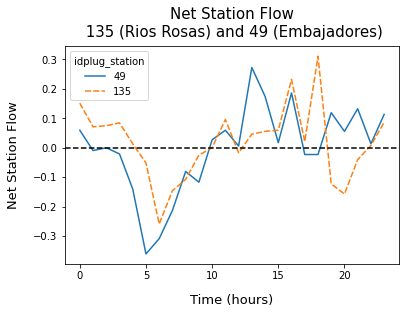

In [74]:
# 135 - 49: Rios Rosas - Embajadores

#Plotting Graph
graph_7 = sns.lineplot(data=high_traffic[[135, 49]])
graph_7.axhline(0, linestyle  = "--", color = "black")

# Annotating Graph
plt.title("Net Station Flow\n 135 (Rios Rosas) and 49 (Embajadores)", size = 15, pad = 10)
plt.ylabel("Net Station Flow", size = 13, labelpad = 13)
plt.xlabel("Time (hours)", size = 13, labelpad = 13)

# 3. Improving traffic identifying main routes through edges weight

#### The idea is to recommend to the local government where they should built bike paths to improve and foster the service.

#### First lets make a copy of the edges csv

In [75]:
edges2 = pd.read_csv("edges2.csv", sep=',')
edges2

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code
0,{'$oid': '5ee862cecc8c1e839b419387'},509e6a72b7673f533912bf647d20df19305b848fbc1b89...,5,1,20,154,44,5,40,2019-07-01T00:00:00Z,28007
1,{'$oid': '5ee862cecc8c1e839b41938c'},90069a1194c3eb9e6faecaaf4eefb7209e890c0df5aeac...,8,1,17,184,57,4,129,2019-07-01T00:00:00Z,28045
2,{'$oid': '5ee862cecc8c1e839b419394'},b0ecaab6a35b7ea44d118f851f7fad5c2237e7dd51b337...,15,1,16,282,53,4,43,2019-07-01T00:00:00Z,NaN
3,{'$oid': '5ee862cecc8c1e839b41939e'},5e1b8a8c4603ee8ac4f06aba12ff51e2c5dd105b6e5193...,18,1,18,388,56,0,13,2019-07-01T00:00:00Z,NaN
4,{'$oid': '5ee862cecc8c1e839b4193a5'},80974c4043db61721399c43f296ce1db4436c7f107f8fc...,1,1,20,254,105,0,75,2019-07-01T00:00:00Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6795872,{'$oid': '60e3815e1b91312850311997'},f6c80276d7cf8829694794d06561c4aea5621e4d222709...,15,3,22,100404,135,0,137,2021-06-30T14:00:00Z,NaN
6795873,{'$oid': '60e3815e1b9131285031199f'},f6c80276d7cf8829694794d06561c4aea5621e4d222709...,14,3,4,94859,236,0,137,2021-06-30T15:00:00Z,NaN
6795874,{'$oid': '60e3816d1b91312850312574'},88e7bc52acd6bdf8fc09723c0299254ec1bbc2f6b3a22e...,14,3,24,212487,231,1,1,2021-06-29T10:00:00Z,NaN
6795875,{'$oid': '60e4d2a51b91313ed4f52e62'},45de608bddfda3f468ef6093c65f6246a2917ce2376e98...,23,1,3,746,234,0,84,2021-06-27T19:00:00Z,NaN


#### Reading stations into dataframe

In [76]:
stations

,Número,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion
0,1,"440443,61","4474290,65",43803,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"ALCALA, CALLE, DE, 2"
1,1,"440480,56","4474301,74",43867,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"ALCALA, CALLE, DE, 6"
2,2,"440134,83","4474678,23",41813,01 CENTRO,01-05 UNIVERSIDAD,"MIGUEL MOYA, CALLE, DE",1,BiciMAD,24,-3.705674,40.420580,"MIGUEL MOYA, CALLE, DE, 1"
3,3,"440012,98","4475760,68",41813,07 CHAMBERÍ,07-02 ARAPILES,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL",2,BiciMAD,18,-3.707212,40.430322,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL, 2"
4,4,"440396,4","4475565,36",41813,01 CENTRO,01-05 UNIVERSIDAD,"MANUELA MALASAÑA, CALLE, DE",3,BiciMAD,24,-3.702674,40.428590,"MANUELA MALASAÑA, CALLE, DE, 3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,257,"438063,25","4476718,06",44194,09 MONCLOA-ARAVACA,09-03 CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24,-3.730290,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1"
260,258,"438326,14","4477849,84",44194,09 MONCLOA-ARAVACA,09-03 CIUDAD UNIVERSITARIA,"COMPLUTENSE, AVENIDA",frente al 14,BiciMAD,24,-3.727300,40.449019,"COMPLUTENSE, AVENIDA, frente al 14"
261,259,"438344,78","4477338,89",44194,09 MONCLOA-ARAVACA,09-03 CIUDAD UNIVERSITARIA,"RAMON Y CAJAL, PLAZA, DE",S/N,BiciMAD,24,-3.727031,40.444418,"RAMON Y CAJAL, PLAZA, DE, S/N"
262,260,"438328,53","4477762,41",44194,09 MONCLOA-ARAVACA,09-03 CIUDAD UNIVERSITARIA,"JOSE ANTONIO NOVAIS, CALLE, DE",S/N,BiciMAD,24,-3.727264,40.448232,"JOSE ANTONIO NOVAIS, CALLE, DE, S/N"


#### Merging both datasets to know main stations and neighborhoods

In [77]:
Combined1 = pd.merge(edges2, stations, left_on=["idunplug_station"],right_on=["Número"], how="outer")

In [78]:
Combined2 = Combined1[['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'Número', 'Gis_X', 'Gis_Y',
       'Fecha de Alta', 'Distrito', 'Barrio', 'Calle', 'Nº Finca',
       'Tipo de Reserva', 'Número de Plazas', 'Longitud', 'Latitud',
       'Direccion','ageRange', 'idplug_station',
       'unplug_hourTime', 'zip_code']]

In [79]:
Combined3 = pd.merge(Combined2, stations, left_on=["idplug_station"],right_on=["Número"], how="outer")

In [80]:
df_Bicimad = Combined3[['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'Número_x', 'Gis_X_x', 'Gis_Y_x',
       'Fecha de Alta_x', 'Distrito_x', 'Barrio_x', 'Calle_x', 'Nº Finca_x',
       'Tipo de Reserva_x', 'Número de Plazas_x', 'Longitud_x', 'Latitud_x',
       'Direccion_x', 'ageRange', 'idplug_station', 'Número_y', 'Gis_X_y', 'Gis_Y_y', 'Fecha de Alta_y',
       'Distrito_y', 'Barrio_y', 'Calle_y', 'Nº Finca_y', 'Tipo de Reserva_y',
       'Número de Plazas_y', 'Longitud_y', 'Latitud_y', 'Direccion_y', 'unplug_hourTime',
       'zip_code']]

In [81]:
df_Bicimad.dropna(inplace=True)

C:\Users\fredi\AppData\Local\Temp\ipykernel_2948\1866343120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bicimad.dropna(inplace=True)


In [82]:
df_Bicimad

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,Número_x,Gis_X_x,Gis_Y_x,...,Barrio_y,Calle_y,Nº Finca_y,Tipo de Reserva_y,Número de Plazas_y,Longitud_y,Latitud_y,Direccion_y,unplug_hourTime,zip_code
0,{'$oid': '5ee862cecc8c1e839b419387'},509e6a72b7673f533912bf647d20df19305b848fbc1b89...,5.0,1.0,20.0,154.0,44.0,44.0,"440274,63","4473482,26",...,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24.0,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",2019-07-01T00:00:00Z,28007
1,{'$oid': '5ee866d82c2e132f37da04bc'},e9267f2e8133fcb9674e640afc82aa2519f32adb0ec490...,24.0,1.0,17.0,431.0,44.0,44.0,"440274,63","4473482,26",...,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24.0,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",2019-07-03T11:00:00Z,28004
3,{'$oid': '5ee890ba1d40f117446f6376'},9983ac77f365a5d13e13706a50f45e65e2c1e732857ae3...,1.0,1.0,20.0,311.0,44.0,44.0,"440274,63","4473482,26",...,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24.0,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",2019-08-12T15:00:00Z,28013
4,{'$oid': '5ee891931d40f117446fcf3a'},2df73c89af38d65d7d8bf4b3aafa86d0f8dc7fd2b0f714...,23.0,1.0,22.0,305.0,44.0,44.0,"440274,63","4473482,26",...,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24.0,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",2019-08-15T10:00:00Z,28012
5,{'$oid': '5ee897da5869a19e1b941abb'},8ede5a8e31d93b7a8dbf30b5b0da7485997ade8df660ea...,19.0,1.0,3.0,254.0,44.0,44.0,"440274,63","4473482,26",...,01-02 EMBAJADORES,"CONDE DE ROMANONES, CALLE, DEL",2,BiciMAD,24.0,-3.704746,40.413787,"CONDE DE ROMANONES, CALLE, DEL, 2",2019-08-22T07:00:00Z,28012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108289,{'$oid': '6025b7081b91312258a84b89'},a9dbef5ebabc256187bdaaf1d7b741420b4ec1d717adf4...,12.0,1.0,2.0,381.0,260.0,260.0,"438328,53","4477762,41",...,09-03 CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24.0,-3.730290,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1",2021-02-07T12:00:00Z,28004
7108292,{'$oid': '6080a0851b913136dc40a2a9'},b808dcb6323d97e07c0b1d2a7ab4dac0db670df0d5b7bc...,22.0,1.0,5.0,1504.0,260.0,260.0,"438328,53","4477762,41",...,09-03 CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24.0,-3.730290,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1",2021-04-17T11:00:00Z,28005
7108297,{'$oid': '60b55cbd1b91312154cb5403'},7e044ebb42c2ec97ac0847b9dd8b3223e031ba5a984cac...,5.0,1.0,21.0,1592.0,251.0,251.0,"443447,95","4477272,58",...,09-03 CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24.0,-3.730290,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1",2021-05-27T17:00:00Z,28001
7108305,{'$oid': '60db98861b913122a8e7816e'},0552543b3ccc3629083543bb406ffe0772eb6ccb17b2ef...,24.0,1.0,5.0,1682.0,253.0,253.0,"441626,91","4478554,58",...,09-03 CIUDAD UNIVERSITARIA,"JUAN DE HERRERA, AVENIDA, DE",1,BiciMAD,24.0,-3.730290,40.438804,"JUAN DE HERRERA, AVENIDA, DE, 1",2021-06-25T17:00:00Z,28008


In [83]:
df_Bicimad.columns

Index(['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'Número_x', 'Gis_X_x', 'Gis_Y_x',
       'Fecha de Alta_x', 'Distrito_x', 'Barrio_x', 'Calle_x', 'Nº Finca_x',
       'Tipo de Reserva_x', 'Número de Plazas_x', 'Longitud_x', 'Latitud_x',
       'Direccion_x', 'ageRange', 'idplug_station', 'Número_y', 'Gis_X_y',
       'Gis_Y_y', 'Fecha de Alta_y', 'Distrito_y', 'Barrio_y', 'Calle_y',
       'Nº Finca_y', 'Tipo de Reserva_y', 'Número de Plazas_y', 'Longitud_y',
       'Latitud_y', 'Direccion_y', 'unplug_hourTime', 'zip_code'],
      dtype='object')

#### Bicimad weights between stations. What are the main routes?

In [84]:
Bicimad_weights = (
    df_Bicimad
    .groupby(["idunplug_station","idplug_station"])["idplug_station"]
    .count()
) 

In [85]:
By_stations = Bicimad_weights[Bicimad_weights>1000].sort_values(ascending = False)

We identify this seven edges over 1000 trips! (From station to station)

In [86]:
By_stations

idunplug_station  idplug_station
9.0               149.0             1590
19.0              55.0              1345
111.0             80.0              1212
65.0              1.0               1098
175.0             43.0              1055
43.0              13.0              1016
135.0             49.0              1011
Name: idplug_station, dtype: int64

#### Main Stations

In [87]:
main_stations = stations.loc[stations['Número'].isin([1,9,13,19,43,49,55,65,80,111,135,149,175])]
#stations.loc[(stations['Número'] == 9) | (stations['Número'] == 43) | (stations['Número'] == 49) | (stations['Número'] == 130)| (stations['Número'] == 135)| (stations['Número'] == 149)| (stations['Número'] == 175)]

In [88]:
main_stations

,Número,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion
0,1,"440443,61","4474290,65",43803,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"ALCALA, CALLE, DE, 2"
1,1,"440480,56","4474301,74",43867,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"ALCALA, CALLE, DE, 6"
9,9,"439813,51","4474129,47",41813,01 CENTRO,01-01 PALACIO,"SAN MIGUEL, PLAZA, DE",9,BiciMAD,24,-3.709409,40.415613,"SAN MIGUEL, PLAZA, DE, 9"
13,13,"439733,78","4475434,65",41813,01 CENTRO,01-05 UNIVERSIDAD,"CONDE DUQUE, CALLE, DEL",22,BiciMAD,24,-3.710473,40.427365,"CONDE DUQUE, CALLE, DEL, 22"
19,19,"441007,98","4474817,8",41813,01 CENTRO,01-04 JUSTICIA,"PRIM, CALLE, DE",4,BiciMAD,24,-3.695395,40.421900,"PRIM, CALLE, DE, 4"
43,43,"440391,04","4473511,6",41813,01 CENTRO,01-02 EMBAJADORES,"LAVAPIES, CALLE, DE",36,BiciMAD,24,-3.702545,40.410089,"LAVAPIES, CALLE, DE, 36"
49,49,"440667,66","4473061,04",41813,01 CENTRO,01-02 EMBAJADORES,"ATOCHA, RONDA, DE",36,BiciMAD,24,-3.699243,40.406050,"ATOCHA, RONDA, DE, 36"
55,55,"440455,56","4475063,26",41813,01 CENTRO,01-05 UNIVERSIDAD,"SAN ILDEFONSO, PLAZA, DE",8,BiciMAD,24,-3.701929,40.424072,"SAN ILDEFONSO, PLAZA, DE, 8"
64,65,"441513,53","4474235,07",41813,03 RETIRO,03-05 JERÓNIMOS,"ANTONIO MAURA, CALLE, DE",15,BiciMAD,24,-3.689382,40.416686,"ANTONIO MAURA, CALLE, DE, 15"
78,80,"441412,24","4473206,43",41813,02 ARGANZUELA,02-07 ATOCHA,"CIUDAD DE BARCELONA, AVENIDA, DE LA",S/N,BiciMAD,24,-3.690482,40.407412,"CIUDAD DE BARCELONA, AVENIDA, DE LA, S/N"


In [89]:
main_edges=([[40.415613,-3.709409],[40.449845,-3.687851]]
            ,[[40.421900,-3.695395],[40.424072,-3.701929]]
            ,[[40.433574,-3.717490],[40.407412,-3.690482]]
            ,[[40.416686,-3.689382],[40.417111,-3.701998]]
            ,[[40.396269,-3.698303],[40.410089,-3.702545]]
            ,[[40.410089,-3.702545],[40.427365,-3.710473]]
            ,[[40.441485,-3.692890],[40.406050,-3.699243]])

#### Let's plot the main routes between stations

To do this we used a library named osmnx (https://osmnx.readthedocs.io/en/stable/) that can found the best route between two points using a real map. To plot it we used folium.
In this case we selected the way of travel = bike, and the optimizer = time (but could be also shortest path)

In [90]:
i=0
for item in main_edges:
   
    ox.config(log_console=True, use_cache=True)
    # define the start and end locations in latlng
    start_latlng = (item[0][0],item[0][1])
    end_latlng = (item[1][0],item[1][1])
    # location where you want to find your route
    place     = 'Madrid, Madrid, Spain'
    # find shortest route based on the mode of travel
    mode      = 'bike'        # 'drive', 'bike', 'walk'
    # find shortest path based on distance or time
    optimizer = 'time'        # 'length','time'
    # create graph from OSM within the boundaries of some 
    # geocodable place(s)
    graph = ox.graph_from_place(place, network_type = mode)
    # find the nearest node to the start location
    orig_node = ox.distance.nearest_nodes(graph, item[0][1],item[0][0])
    # find the nearest node to the end location
    dest_node = ox.distance.nearest_nodes(graph, item[1][1],item[1][0])
    #  find the shortest path
    globals()[f"shortest_route_{i}"] = nx.shortest_path(graph,
                                      orig_node,
                                      dest_node,
                                      weight=optimizer)
    i = i + 1

C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.p

We added over the same map each of the main edges with diff colors, and voila!
We can see castellana and downtown two pillars for the bike transportation. 
With the next point, trips between neighbourhoods, we could see better our recommendations.

In [91]:
shortest_route_map = ox.plot_route_folium(graph, shortest_route_0)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_1, route_map=shortest_route_map, color='red')
shortest_route_map = ox.plot_route_folium(graph, shortest_route_2, route_map=shortest_route_map, color='green')
shortest_route_map = ox.plot_route_folium(graph, shortest_route_3, route_map=shortest_route_map, color='yellow')
shortest_route_map = ox.plot_route_folium(graph, shortest_route_4, route_map=shortest_route_map, color='pink')
shortest_route_map = ox.plot_route_folium(graph, shortest_route_5, route_map=shortest_route_map, color='black')
shortest_route_map = ox.plot_route_folium(graph, shortest_route_6, route_map=shortest_route_map, color='brown')

shortest_route_map

In [92]:
bike_station_locations = main_stations[["Latitud", "Longitud", "Número"]]

In [93]:
bike_station_locations

,Latitud,Longitud,Número
0,40.417111,-3.701998,1
1,40.417213,-3.701564,1
9,40.415613,-3.709409,9
13,40.427365,-3.710473,13
19,40.421900,-3.695395,19
43,40.410089,-3.702545,43
49,40.406050,-3.699243,49
55,40.424072,-3.701929,55
64,40.416686,-3.689382,65
78,40.407412,-3.690482,80


Here we add the flags to improve the visualization.
If you click on it, you could see the station number, so can be identified the edges easily.

In [94]:
final_map = folium.Map(location=[bike_station_locations.Latitud.mean(), bike_station_locations.Longitud.mean()], zoom_start=14, control_scale=True)

In [95]:
for index, location_info in bike_station_locations.iterrows():
    folium.Marker([location_info["Latitud"], location_info["Longitud"]], popup=location_info["Número"]).add_to(shortest_route_map)

In [96]:
shortest_route_map

#### Plotting By Neighbourhood. 
Why by neighbourhood? Because we want to generalize more and to build cycling roads around Madrid.

In [97]:
Bicimad_barrio_weights = (
    df_Bicimad #filter bycolumns
    .groupby(["Barrio_x","Barrio_y"])["Barrio_y"]
    .count()
)

In [98]:
By_Barrio = Bicimad_barrio_weights[Bicimad_barrio_weights>8000].sort_values(ascending = False)

#### The sum of edges between this sixteen neighbourhoods is around a 5% of all the edges. Could look a few but we need to take in account than Madrid has more than 131 neighbourhoods.

In [99]:
By_Barrio

Barrio_x           Barrio_y         
01-02 EMBAJADORES  01-02 EMBAJADORES    20716
01-05 UNIVERSIDAD  01-02 EMBAJADORES    20452
01-02 EMBAJADORES  01-05 UNIVERSIDAD    18536
07-05 RÍOS ROSAS   01-02 EMBAJADORES    16166
01-02 EMBAJADORES  01-04 JUSTICIA       15508
                   07-05 RÍOS ROSAS     15242
01-04 JUSTICIA     01-02 EMBAJADORES    14971
01-02 EMBAJADORES  01-06 SOL            13972
01-05 UNIVERSIDAD  01-04 JUSTICIA       12802
01-04 JUSTICIA     01-05 UNIVERSIDAD    12256
01-06 SOL          01-02 EMBAJADORES    11721
01-05 UNIVERSIDAD  01-05 UNIVERSIDAD    11291
01-02 EMBAJADORES  01-01 PALACIO        10476
04-01 RECOLETOS    04-01 RECOLETOS      10428
01-04 JUSTICIA     01-04 JUSTICIA        9680
07-05 RÍOS ROSAS   01-05 UNIVERSIDAD     9575
01-01 PALACIO      01-02 EMBAJADORES     9554
01-05 UNIVERSIDAD  02-02 ACACIAS         9379
01-03 CORTES       01-02 EMBAJADORES     9281
01-05 UNIVERSIDAD  07-05 RÍOS ROSAS      9161
01-04 JUSTICIA     02-02 ACACIAS         85

In [100]:
By_Barrio.sum()

328720

### The from and to per barrio are selected base in our city knowledge. Main squares of each barrio are selected as reference points. For example, 01-06 Sol, has La Puerta del Sol as main from-to coordinates.

In [101]:
barrio_edges=([[40.428940,-3.702279],[40.404744,-3.702803]]
            ,[[40.446702,-3.703755],[40.404744,-3.702803]]
            ,[[40.404744,-3.702803],[40.427640,-3.695794]]
            ,[[40.404744,-3.702803],[40.416719,-3.703417]]
            ,[[40.428940,-3.702279],[40.427640,-3.695794]]
            ,[[40.416719,-3.703417],[40.428940,-3.702279]]
            ,[[40.428940,-3.702279],[40.418013,-3.709411]]
            ,[[40.446702,-3.703755],[40.428940,-3.702279]]
            ,[[40.418013,-3.709411],[40.404744,-3.702803]]
            ,[[40.428940,-3.702279],[40.400936,-3.713995]]
             ,[[40.419089,-3.693003],[40.404744,-3.702803]]
             ,[[40.427640,-3.695794],[40.400936,-3.713995]]
             ,[[40.432561,-3.683532],[40.400936,-3.713995]]
             ,[[40.427838,-3.668723],[40.432561,-3.683532]]
             ,[[40.427640,-3.695794],[40.446702,-3.703755]]
             ,[[40.404744,-3.702803],[40.400936,-3.713995]])

In [102]:
i=0
for item in barrio_edges:
   
    ox.config(log_console=True, use_cache=True)
    # define the start and end locations in latlng
    start_latlng = (item[0][0],item[0][1])
    end_latlng = (item[1][0],item[1][1])
    # location where you want to find your route
    place     = 'Madrid, Madrid, Spain'
    # find shortest route based on the mode of travel
    mode      = 'bike'        # 'drive', 'bike', 'walk'
    # find shortest path based on distance or time
    optimizer = 'time'        # 'length','time'
    # create graph from OSM within the boundaries of some 
    # geocodable place(s)
    graph = ox.graph_from_place(place, network_type = mode)
    # find the nearest node to the start location
    orig_node = ox.distance.nearest_nodes(graph, item[0][1],item[0][0])
    # find the nearest node to the end location
    dest_node = ox.distance.nearest_nodes(graph, item[1][1],item[1][0])
    #  find the shortest path
    globals()[f"shortest_route_{i}"] = nx.shortest_path(graph,
                                      orig_node,
                                      dest_node,
                                      weight=optimizer)
    i = i + 1

C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
C:\Users\fredi\anaconda3\envs\ox\lib\site-packages\osmnx\utils.p

In [103]:
shortest_route_map = ox.plot_route_folium(graph, shortest_route_0)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_1, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_2, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_3, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_4, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_5, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_6, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_7, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_8, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_9, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_10, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_11, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_12, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_13, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_14, route_map=shortest_route_map)
shortest_route_map = ox.plot_route_folium(graph, shortest_route_15, route_map=shortest_route_map)

shortest_route_map

#### Now, lets plot all the stations wihin these sixteen barrios.
#### We can see, that with a few bike roads we can serve all those stations, as they are clustered around our highlighted route.

In [104]:
stations_per_barrio = stations.loc[stations['Barrio'].isin(["01-02 EMBAJADORES", "01-05 UNIVERSIDAD", "07-05 RÍOS ROSAS", "01-04 JUSTICIA","01-06 SOL","01-01 PALACIO","04-01 RECOLETOS", "02-02 ACACIAS","01-03 CORTES", "04-02 GOYA"])]

In [105]:
bike_station_locations_per_barrio = stations_per_barrio[["Latitud", "Longitud", "Número"]]

In [106]:
bike_station_locations_per_barrio

,Latitud,Longitud,Número
0,40.417111,-3.701998,1
1,40.417213,-3.701564,1
2,40.420580,-3.705674,2
4,40.428590,-3.702674,4
5,40.428362,-3.702074,5
...,...,...,...
185,40.425636,-3.669451,183
203,40.438732,-3.703816,201
212,40.419754,-3.702631,210
213,40.420617,-3.702537,211


In [107]:
final_map = folium.Map(location=[bike_station_locations_per_barrio.Latitud.mean(), bike_station_locations_per_barrio.Longitud.mean()], zoom_start=14, control_scale=True)

In [108]:
for index, location_info in bike_station_locations_per_barrio.iterrows():
    folium.Marker([location_info["Latitud"], location_info["Longitud"]], popup=location_info["Número"]).add_to(shortest_route_map)

(The only case that OSMNX does not show the right route is the one that goes to the east side of the map. The bikes can go through calle Alcala, much easier than around Salamana neighbourhood)

In [109]:
shortest_route_map

In [129]:
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_0)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_1, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_2, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_3, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_4, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_5, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_6, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_7, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_8, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_9, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_10, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_11, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_12, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_13, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_14, route_map=shortest_route_map2)
shortest_route_map2 = ox.plot_route_folium(graph, shortest_route_15, route_map=shortest_route_map2)

In [111]:
import folium.plugins

In [112]:
folium.plugins.MarkerCluster()

In [113]:
from folium.plugins import MarkerCluster
MarkerCluster()

In [114]:
locations = stations_per_barrio[["Latitud", "Longitud",]]

In [115]:
locationlist = locations.values.tolist()

In [116]:
marker_cluster = MarkerCluster().add_to(shortest_route_map2)

In [117]:
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
shortest_route_map2

# 4. Selfloops insights

In [118]:
selfloops = pd.read_csv('edges_selfloops.csv')
selfloops.head(1)

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code
0,{'$oid': '5ee862cfcc8c1e839b4193d6'},ea91776b5ee4da36d37b49da20725893d68dd9b2fcf823...,16,1,22,1228,207,0,207,2019-07-01T00:00:00Z,NaN


In [119]:
keys = stations.copy()
keys.head(1)

,Número,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion
0,1,"440443,61","4474290,65",43803,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"ALCALA, CALLE, DE, 2"


In [120]:
selfloops.rename(columns={'idunplug_station':'from', 'idplug_station':'to', 'travel_time':'weight'}, inplace=True)

selfloops = selfloops[['from','to', 'weight']]

In [121]:
selfloops

,from,to,weight
0,207,207,1228
1,88,88,202
2,57,57,1606
3,183,183,1405
4,1,1,1056
...,...,...,...
363880,41,41,2696
363881,186,186,7721
363882,268,268,355190
363883,253,253,603181


## Distribution of selflooops

In [122]:
selfloops

,from,to,weight
0,207,207,1228
1,88,88,202
2,57,57,1606
3,183,183,1405
4,1,1,1056
...,...,...,...
363880,41,41,2696
363881,186,186,7721
363882,268,268,355190
363883,253,253,603181


In [123]:
# Clipping the extreme values within the 99% percentile and changing the seconds to minutes.
selfloops['weight_min'] = winsorize(selfloops['weight'], limits=[0.01, 0.01])/60 

# Adding the trip count.
selfloops['trip_count'] = selfloops.groupby('from').count()['to']

In [124]:
sl_data = Graph.DataFrame(edges=selfloops, vertices=selfloops, directed=False, use_vids=True)
sl_data.vs['degree'] = sl_data.degree(mode='all')

In [125]:
selfloops["weight_min"].groupby(selfloops["from"]).mean().sort_values(ascending=False)

from
2008    49.260606
132     46.140730
224     40.188849
64      39.079539
197     38.993486
          ...    
111      6.059930
252      5.905145
266      4.896523
270      3.454792
258      2.601566
Name: weight_min, Length: 266, dtype: float64

In [126]:
selfloops

,from,to,weight,weight_min,trip_count
0,207,207,1228,20.466667,NaN
1,88,88,202,3.366667,1206.0
2,57,57,1606,26.766667,840.0
3,183,183,1405,23.416667,1515.0
4,1,1,1056,17.600000,1654.0
...,...,...,...,...,...
363880,41,41,2696,44.933333,NaN
363881,186,186,7721,128.683333,NaN
363882,268,268,355190,235.083333,NaN
363883,253,253,603181,235.083333,NaN


In [127]:
# Dividing the loops in intentional (loops with more than 3 minute) and unintentional (loops with less than 1 minute).
selfloops['type'] = np.where(selfloops['weight_min'] > 1, 'intentional', 'unintentional')

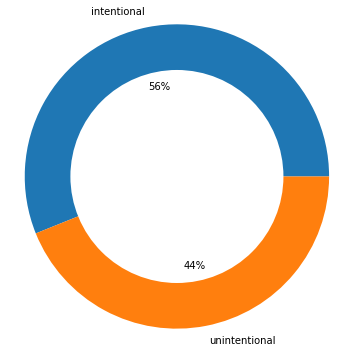

In [128]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(selfloops['type'].value_counts(), labels=selfloops['type'].value_counts().index, autopct='%1.f%%')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  
plt.tight_layout()
plt.show()